In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
import dask
from dask.dot import dot_graph
from elfi import *
from elfi.examples.ma2 import MA2, autocov, distance
from distributed import Client
from functools import partial

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
# Setup distributed
# client = Client()
# dask.set_options(get=client.get)

In [3]:
n = 100
t1_0 = 0.6
t2_0 = 0.2

# Set up observed data y
latents = np.random.randn(n+2)
y = MA2(n, t1_0, t2_0, n_sim=1, latents=latents)

# Plot
# plt.figure(figsize=(11, 6));
# plt.plot(np.arange(0,n),y[0,:]);
# plt.scatter(np.arange(-2,n), latents);

In [4]:
# Set up the simulator
simulator = partial(MA2, n)

# Set up autocovariance summaries
ac1 = partial(autocov, 1)
ac2 = partial(autocov, 2)

# Specify the graphical model
t1 = Prior('t1', 'uniform', 0, 1)
t2 = Prior('t2', 'uniform', 0, 1)
Y = Simulator('MA2', simulator, t1, t2, observed=y)
S1 = Summary('S1', ac1, Y)
S2 = Summary('S2', ac2, Y)
d = Discrepancy('d', distance, S1, S2, store=MemoryStore())

In [5]:
# Specify the number of simulations and set up rejection sampling
N = 50000
rej = Rejection(N, d, [t1, t2], 100000)

In [6]:
# Time and run the simulator in parallel
%time result = rej.infer(quantile=0.01)

CPU times: user 1.72 s, sys: 323 ms, total: 2.04 s
Wall time: 6.58 s


In [7]:
%time result = rej.infer(quantile=0.01)

CPU times: user 395 ms, sys: 44.7 ms, total: 440 ms
Wall time: 608 ms


In [8]:
[t1_post, t2_post] = result['samples']
print("Number of accepted samples {} with threshold {:.2f}".format(len(t1_post), result['threshold']))
print("Posterior means: {:.2f} {:.2f}".format(t1_post.mean(), t2_post.mean()))

Number of accepted samples 20000 with threshold 0.07
Posterior means: 0.51 0.09


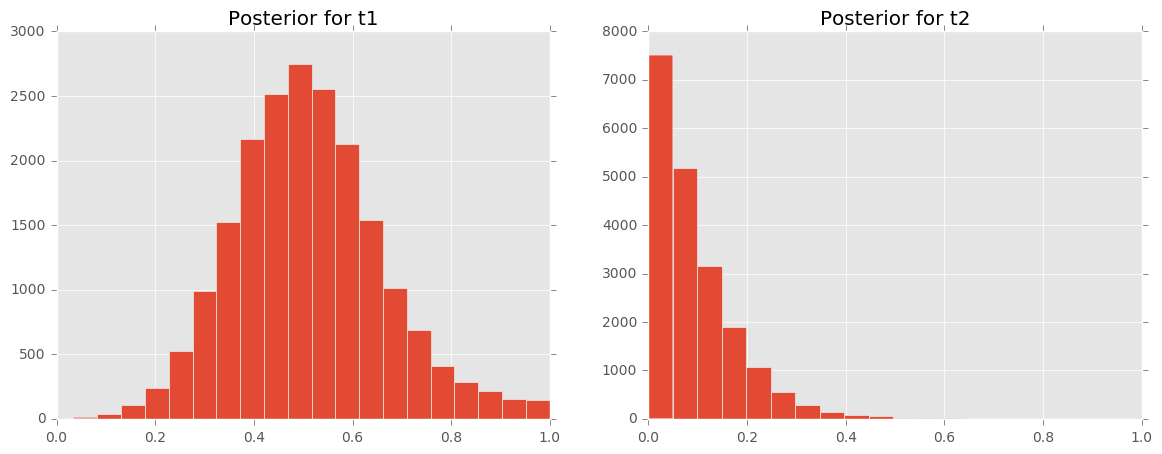

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(14,5));
ax[0].hist(t1_post, bins=20);
ax[0].set_title("Posterior for t1");
ax[1].hist(t2_post, bins=20);
ax[1].set_title("Posterior for t2");